In [ ]:
"""
Handwritten Text Recognition Using Deep Learning: A CNN-LSTM Approach
"""

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# ============================================================================
# 1. PREPROCESSING FUNCTIONS
# ============================================================================

def grayscale_conversion(image):
    """Convert RGB image to grayscale using weighted sum"""
    if len(image.shape) == 3:
        # Formula: I_gray = 0.2989*R + 0.5870*G + 0.1140*B
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    return gray


def binarization(gray_image, method='otsu'):
    """Apply thresholding to convert grayscale to binary"""
    if method == 'otsu':
        _, binary = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'huang':
        threshold = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)[0]
        _, binary = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY)
    else:
        _, binary = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    return binary


def resize_and_pad(image, target_height=32, target_width=128):
    """Resize image to fixed dimensions with padding"""
    h, w = image.shape[:2]
    
    # Calculate scaling factor to maintain aspect ratio
    scale = min(target_height / h, target_width / w)
    new_h, new_w = int(h * scale), int(w * scale)
    
    # Resize image
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create padded image with white background
    padded = np.ones((target_height, target_width), dtype=np.uint8) * 255
    
    # Calculate padding offsets
    y_offset = (target_height - new_h) // 2
    x_offset = (target_width - new_w) // 2
    
    # Place resized image in center
    padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    return padded


def image_inversion(binary_image):
    """Invert pixel intensities (black text on white becomes white text on black)"""
    inverted = 255 - binary_image
    return inverted


def normalize_image(image):
    """Normalize pixel values to range [0, 1]"""
    normalized = image.astype(np.float32) / 255.0
    return normalized


def preprocess_image(image_path, target_height=32, target_width=128):
    """Complete preprocessing pipeline"""
    # Read image
    image = cv2.imread(str(image_path))
    
    # Step 1: Grayscale conversion
    gray = grayscale_conversion(image)
    
    # Step 2: Binarization
    binary = binarization(gray, method='otsu')
    
    # Step 3: Resize and pad
    resized = resize_and_pad(binary, target_height, target_width)
    
    # Step 4: Image inversion (optional, depending on dataset)
    # inverted = image_inversion(resized)
    
    # Step 5: Normalization
    normalized = normalize_image(resized)
    
    # Add channel dimension
    preprocessed = np.expand_dims(normalized, axis=-1)
    
    return preprocessed


# ============================================================================
# 2. CHARACTER ENCODING
# ============================================================================

class CharacterEncoder:
    """Encode and decode characters for model training"""
    
    def __init__(self, characters=None):
        if characters is None:
            # Default character set (lowercase + uppercase + digits + space)
            self.characters = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789.,!?'-"
        else:
            self.characters = characters
        
        # Create character to index mapping (start from 0)
        # CTC blank token will be at index len(characters) automatically
        self.char_to_num = {char: idx for idx, char in enumerate(self.characters)}
        
        # Create index to character mapping
        self.num_to_char = {idx: char for char, idx in self.char_to_num.items()}
        
        # Vocab size includes all characters + blank token at the end
        self.vocab_size = len(self.characters) + 1  # +1 for CTC blank
        self.blank_token_idx = len(self.characters)  # Blank is last index
    
    def encode(self, text):
        """Encode text to numerical indices (0 to len(characters)-1)"""
        encoded = []
        for char in text:
            if char in self.char_to_num:
                encoded.append(self.char_to_num[char])
            # Skip unknown characters instead of using blank
        return encoded
    
    def decode(self, indices):
        """Decode numerical indices to text (skip blank token)"""
        decoded = []
        for idx in indices:
            if idx < len(self.characters) and idx in self.num_to_char:
                decoded.append(self.num_to_char[idx])
            # Skip blank token (self.blank_token_idx) and unknown indices
        return ''.join(decoded)


# ============================================================================
# 3. CNN-LSTM MODEL ARCHITECTURE
# ============================================================================

def build_crnn_model(input_shape=(32, 128, 1), num_classes=79):
    """
    Build CRNN model with 6 Conv layers and 2 BiLSTM layers
    Architecture from the paper
    """
    
    # Input layer
    input_layer = layers.Input(shape=input_shape, name='input_1')
    
    # Convolutional Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2d')(input_layer)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d')(x)
    
    # Convolutional Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2d_1')(x)
    x = layers.MaxPooling2D((2, 2), name='max_pooling2d_1')(x)
    
    # Convolutional Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv2d_2')(x)
    
    # Convolutional Block 4
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv2d_3')(x)
    x = layers.MaxPooling2D((2, 1), name='max_pooling2d_2')(x)
    
    # Convolutional Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2d_4')(x)
    x = layers.BatchNormalization(name='batch_normalization')(x)
    
    # Convolutional Block 6
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv2d_5')(x)
    x = layers.BatchNormalization(name='batch_normalization_1')(x)
    x = layers.MaxPooling2D((2, 1), name='max_pooling2d_3')(x)
    
    # Convolutional Block 7
    x = layers.Conv2D(512, (2, 2), activation='relu', name='conv2d_6')(x)
    
    # Reshape for LSTM (Lambda layer)
    # Shape: (batch, height, width, channels) -> (batch, width, height*channels)
    x = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name='lambda')(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2), 
                            name='bidirectional')(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2), 
                            name='bidirectional_1')(x)
    
    # Dense output layer
    output = layers.Dense(num_classes, activation='softmax', name='dense')(x)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output, name='CRNN_HTR')
    
    return model


# ============================================================================
# 4. CTC LOSS FUNCTION
# ============================================================================

def ctc_loss_function(y_true, y_pred):
    """CTC (Connectionist Temporal Classification) loss"""
    # Get batch size
    batch_size = tf.shape(y_true)[0]
    
    # Input length (time steps from model output)
    input_length = tf.shape(y_pred)[1] * tf.ones(shape=(batch_size, 1), dtype='int32')
    
    # Label length (actual label sequence length)
    label_length = tf.reduce_sum(tf.cast(y_true != 0, tf.int32), axis=-1, keepdims=True)
    
    # Calculate CTC loss
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    
    return loss


# ============================================================================
# 5. DATA GENERATOR
# ============================================================================

class HTRDataGenerator(keras.utils.Sequence):
    """Data generator for HTR training"""
    
    def __init__(self, image_paths, labels, encoder, batch_size=5, 
                 img_height=32, img_width=128, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.encoder = encoder
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        """Number of batches per epoch"""
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Generate data
        X, y = self.__data_generation(indexes)
        
        return X, y
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, indexes):
        """Generate data for a batch"""
        # Initialize arrays
        X = np.zeros((self.batch_size, self.img_height, self.img_width, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, 64), dtype=np.int32)  # Max label length = 64
        
        # Generate data
        for i, idx in enumerate(indexes):
            # Load and preprocess image
            img = preprocess_image(self.image_paths[idx], self.img_height, self.img_width)
            X[i] = img
            
            # Encode label
            encoded_label = self.encoder.encode(self.labels[idx])
            y[i, :len(encoded_label)] = encoded_label
        
        return X, y


# ============================================================================
# 6. JARO-WINKLER SIMILARITY
# ============================================================================

def jaro_winkler_similarity(str1, str2):
    """Calculate Jaro-Winkler similarity between two strings"""
    
    def jaro_similarity(s1, s2):
        if len(s1) == 0 and len(s2) == 0:
            return 1.0
        if len(s1) == 0 or len(s2) == 0:
            return 0.0
        
        match_distance = max(len(s1), len(s2)) // 2 - 1
        s1_matches = [False] * len(s1)
        s2_matches = [False] * len(s2)
        
        matches = 0
        transpositions = 0
        
        for i in range(len(s1)):
            start = max(0, i - match_distance)
            end = min(i + match_distance + 1, len(s2))
            
            for j in range(start, end):
                if s2_matches[j] or s1[i] != s2[j]:
                    continue
                s1_matches[i] = True
                s2_matches[j] = True
                matches += 1
                break
        
        if matches == 0:
            return 0.0
        
        k = 0
        for i in range(len(s1)):
            if not s1_matches[i]:
                continue
            while not s2_matches[k]:
                k += 1
            if s1[i] != s2[k]:
                transpositions += 1
            k += 1
        
        return (matches / len(s1) + matches / len(s2) + 
                (matches - transpositions / 2) / matches) / 3
    
    jaro_sim = jaro_similarity(str1, str2)
    
    # Calculate prefix length (max 4)
    prefix = 0
    for i in range(min(len(str1), len(str2), 4)):
        if str1[i] == str2[i]:
            prefix += 1
        else:
            break
    
    # Calculate Jaro-Winkler similarity
    jaro_winkler = jaro_sim + (prefix * 0.1 * (1 - jaro_sim))
    
    return jaro_winkler


# ============================================================================
# 7. TRAINING FUNCTION
# ============================================================================

def train_model(model, train_generator, val_generator, epochs=50, 
                checkpoint_path='best_model.h5'):
    """Train the CRNN model"""
    
    # Compile model with SGD optimizer
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss=ctc_loss_function)
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )
    
    return history


# ============================================================================
# 8. PREDICTION AND DECODING
# ============================================================================

def decode_predictions(predictions, encoder, blank_index=None):
    """Decode CTC predictions to text
    
    Args:
        predictions: numpy array of shape (batch_size, time_steps, num_classes)
        encoder: CharacterEncoder instance
        blank_index: Index of blank token (optional, uses encoder.blank_token_idx)
    
    Returns:
        List of decoded text strings
    """
    if blank_index is None:
        blank_index = encoder.blank_token_idx
    
    decoded_texts = []
    
    # predictions shape: (batch_size, time_steps, num_classes)
    batch_size = predictions.shape[0]
    time_steps = predictions.shape[1]
    
    # Create input_length for all samples in batch
    input_lengths = np.full((batch_size,), time_steps, dtype=np.int32)
    
    # Decode all predictions at once
    decoded, _ = tf.keras.backend.ctc_decode(
        predictions,
        input_length=input_lengths,
        greedy=True
    )
    
    # Convert to text
    decoded = decoded[0].numpy()
    for i in range(batch_size):
        # Get the decoded sequence for this sample
        seq = decoded[i]
        # Decode to text using encoder
        text = encoder.decode(seq)
        decoded_texts.append(text)
    
    return decoded_texts


# ============================================================================
# 9. VISUALIZATION FUNCTIONS
# ============================================================================

def plot_training_history(history, epochs_trained):
    """Plot training and validation accuracy/loss"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Training and Validation Loss ({epochs_trained} Epochs)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy (if available)
    if 'accuracy' in history.history:
        ax2.plot(history.history['accuracy'], label='Training Accuracy')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title(f'Training and Validation Accuracy ({epochs_trained} Epochs)')
        ax2.legend()
        ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'training_history_{epochs_trained}_epochs.png')
    plt.show()


def visualize_predictions(image_paths, true_labels, predicted_labels, num_samples=5):
    """Visualize predictions with original images"""
    
    num_samples = min(num_samples, len(image_paths))
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, num_samples * 2))
    
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        # Load and display image
        img = cv2.imread(image_paths[i], cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        
        # Calculate similarity
        similarity = jaro_winkler_similarity(true_labels[i], predicted_labels[i])
        
        # Set title with true and predicted text
        title = f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]}\nSimilarity: {similarity:.2%}"
        axes[i].set_title(title, fontsize=10)
    
    plt.tight_layout()
    plt.savefig('prediction_samples.png')
    plt.show()


# ============================================================================
# 10. MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""
    
    print("=" * 80)
    print("Handwritten Text Recognition Using CNN-LSTM")
    print("=" * 80)
    
    # Initialize character encoder
    print("\n[1/7] Initializing character encoder...")
    encoder = CharacterEncoder()
    print(f"Vocabulary size: {encoder.vocab_size}")
    
    # Build model
    print("\n[2/7] Building CRNN model...")
    model = build_crnn_model(input_shape=(32, 128, 1), num_classes=encoder.vocab_size)
    model.summary()
    
    # Print model statistics
    total_params = model.count_params()
    print(f"\nTotal parameters: {total_params:,}")
    
    print("\n[3/7] Model architecture successfully created!")
    print("\nNote: To train the model, you need:")
    print("  - IAM Dataset with image paths and labels")
    print("  - Create train/validation data generators")
    print("  - Call train_model() function")
    
    print("\n[4/7] Example usage:")
    print("""
    # Example: Load your dataset
    train_images = ['path/to/image1.png', 'path/to/image2.png', ...]
    train_labels = ['hello', 'world', ...]
    
    # Create data generator
    train_gen = HTRDataGenerator(train_images, train_labels, encoder, batch_size=5)
    val_gen = HTRDataGenerator(val_images, val_labels, encoder, batch_size=5)
    
    # Train model
    history = train_model(model, train_gen, val_gen, epochs=50)
    
    # Evaluate
    predictions = model.predict(test_images)
    decoded = decode_predictions(predictions, encoder)
    """)
    
    print("\n[5/7] Preprocessing example:")
    # Create a sample image for demonstration
    sample_img = np.ones((50, 200, 3), dtype=np.uint8) * 255
    cv2.putText(sample_img, "SAMPLE", (10, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    cv2.imwrite('sample_input.png', sample_img)
    
    # Preprocess it
    preprocessed = preprocess_image('sample_input.png')
    print(f"Preprocessed shape: {preprocessed.shape}")
    print(f"Value range: [{preprocessed.min():.2f}, {preprocessed.max():.2f}]")
    
    print("\n[6/7] Character encoding example:")
    sample_text = "Hello World"
    encoded = encoder.encode(sample_text)
    decoded = encoder.decode(encoded)
    print(f"Original: {sample_text}")
    print(f"Encoded: {encoded}")
    print(f"Decoded: {decoded}")
    
    print("\n[7/7] Jaro-Winkler similarity example:")
    text1 = "recognition"
    text2 = "recogniton"
    similarity = jaro_winkler_similarity(text1, text2)
    print(f"'{text1}' vs '{text2}': {similarity:.2%}")
    
    print("\n" + "=" * 80)
    print("Setup complete! Model ready for training.")
    print("=" * 80)
    
    return model, encoder


if __name__ == "__main__":
    model, encoder = main()


2025-10-20 08:44:29.441555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760949869.629597      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760949869.689226      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Handwritten Text Recognition Using CNN-LSTM

[1/7] Initializing character encoder...
Vocabulary size: 70

[2/7] Building CRNN model...


I0000 00:00:1760949882.461585      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760949882.462269      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "CRNN_HTR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 128, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 32, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 32, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 32, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 32, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 31, 512)     │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 31, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31, 70)         │        35,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,738,630 (33.34 MB)

 Trainable params: 8,736,582 (33.33 MB)

 Non-trainable params: 2,048 (8.00 KB)


Total parameters: 8,738,630

[3/7] Model architecture successfully created!

Note: To train the model, you need:
  - IAM Dataset with image paths and labels
  - Create train/validation data generators
  - Call train_model() function

[4/7] Example usage:

    # Example: Load your dataset
    train_images = ['path/to/image1.png', 'path/to/image2.png', ...]
    train_labels = ['hello', 'world', ...]
    
    # Create data generator
    train_gen = HTRDataGenerator(train_images, train_labels, encoder, batch_size=5)
    val_gen = HTRDataGenerator(val_images, val_labels, encoder, batch_size=5)
    
    # Train model
    history = train_model(model, train_gen, val_gen, epochs=50)
    
    # Evaluate
    predictions = model.predict(test_images)
    decoded = decode_predictions(predictions, encoder)
    

[5/7] Preprocessing example:
Preprocessed shape: (32, 128, 1)
Value range: [0.00, 1.00]

[6/7] Character encoding example:
Original: Hello World
Encoded: [34, 5, 12, 12, 15, 0, 49, 15, 18, 1

HANDWRITTEN TEXT RECOGNITION - IAM DATASET TRAINING

STEP 1: LOADING IAM DATASET

Validating dataset at: /kaggle/input/iam-handwriting-word-database
✓ Base path: /kaggle/input/iam-handwriting-word-database
✓ Words directory: /kaggle/input/iam-handwriting-word-database/iam_words/words
✓ Annotation file: /kaggle/input/iam-handwriting-word-database/words_new.txt
✓ IAM Dataset paths validated successfully

Loading IAM words from: /kaggle/input/iam-handwriting-word-database/words_new.txt
✓ Loaded 38305 samples, skipped 6259 samples

DATASET STATISTICS
Total samples: 38,305
Text length - Min: 1, Max: 19, Avg: 4.30
Unique characters: 77
Character set:  !"#'()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXY...

STEP 2: PREPARING DATA

Splitting data: Train/Val/Test
✓ Train: 27675 samples (72.2%)
✓ Validation: 4884 samples (12.8%)
✓ Test: 5746 samples (15.0%)

✓ Character set created: 77 unique characters
Characters:  !"#'()*,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz...

✓

Model: "CRNN_HTR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 128, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 32, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 32, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 32, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 32, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 32, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 31, 512)     │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 31, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 31, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31, 78)         │        40,014 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,742,734 (33.35 MB)

 Trainable params: 8,740,686 (33.34 MB)

 Non-trainable params: 2,048 (8.00 KB)


STEP 5: TRAINING MODEL
Epochs: 50
Batch size: 32
Model will be saved to: htr_model_20251020_084444.weights.h5



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1760950033.093127     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


397/864 ━━━━━━━━━━━━━━━━━━━━ 1:53 243ms/step - loss: 17.0314
864/864 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 15.1695
Epoch 1: val_loss improved from inf to 13.47484, saving model to htr_model_20251020_084444.weights.weights.h5
864/864 ━━━━━━━━━━━━━━━━━━━━ 260s 285ms/step - loss: 15.1670 - val_loss: 13.4748 - learning_rate: 0.0010
Epoch 2/50
  4/864 ━━━━━━━━━━━━━━━━━━━━ 1:14 86ms/step - loss: 10.5602
864/864 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 10.4148
Epoch 2: val_loss improved from 13.47484 to 9.25954, saving model to htr_model_20251020_084444.weights.weights.h5
864/864 ━━━━━━━━━━━━━━━━━━━━ 63s 73ms/step - loss: 10.4143 - val_loss: 9.2595 - learning_rate: 0.0010
Epoch 3/50
643/864 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 8.3742
864/864 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 8.2590
Epoch 3: val_loss improved from 9.25954 to 7.09991, saving model to htr_model_20251020_084444.weights.weights.h5
864/864 ━━━━━━━━━━━━━━━━━━━━ 63s 73ms/step - loss: 8.2584 - val_loss: 7.0999 - le

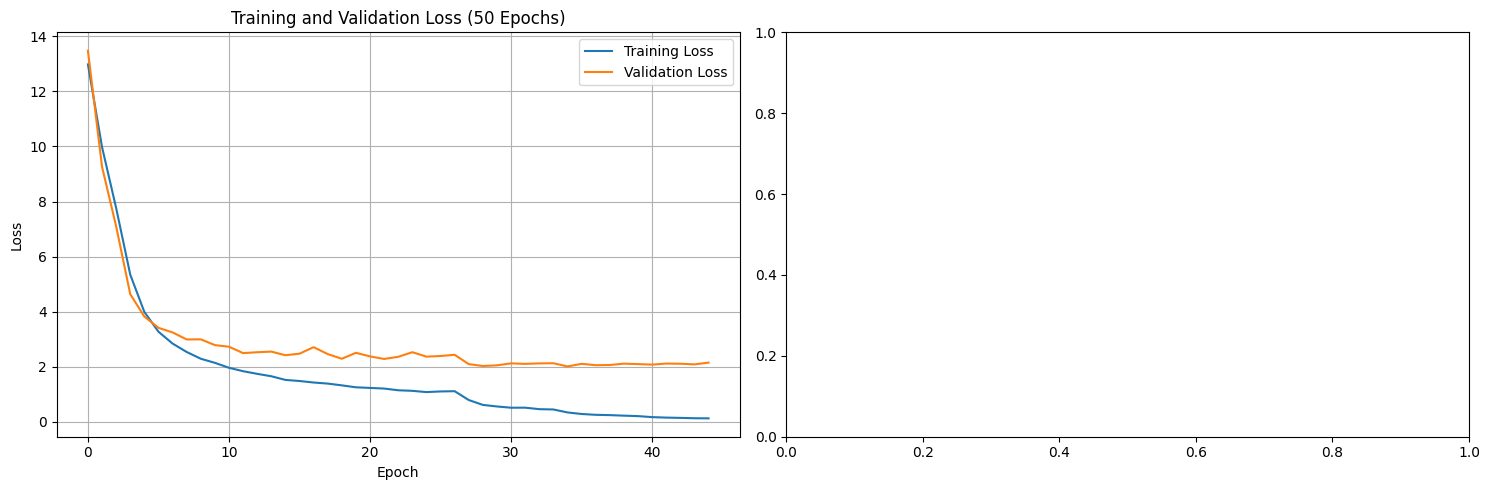


STEP 7: EVALUATING MODEL

EVALUATING MODEL
Preprocessing 100 images...
  Processed 100/100 images...

Making predictions...
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step
Decoding predictions...

Calculating metrics...

EVALUATION RESULTS
Samples evaluated: 100
Exact match accuracy: 79.00%
Average similarity: 84.58%
Median similarity: 100.00%
Character Error Rate (CER): 5.77%
Word Error Rate (WER): 21.00%
✓ Predictions saved to: predictions_20251020_084444.txt

STEP 8: VISUALIZING PREDICTIONS


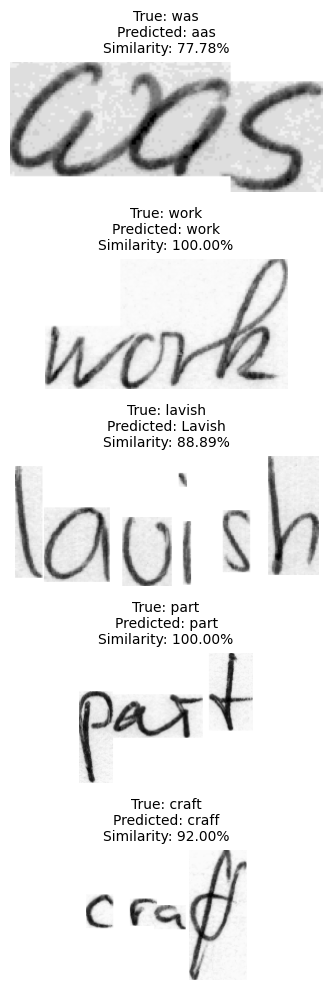


TRAINING COMPLETE!
✓ Model saved: htr_model_20251020_084444.weights.h5
✓ Encoder saved: encoder_20251020_084444.pkl
✓ History saved: history_20251020_084444.pkl
✓ Predictions saved: predictions_20251020_084444.txt

Final Performance:
  - Character Error Rate (CER): 5.77%
  - Word Error Rate (WER): 21.00%
  - Average Similarity: 84.58%



In [ ]:
"""
Training Script for Handwritten Text Recognition using IAM Dataset
This script loads the IAM dataset, trains the CNN-LSTM model, and evaluates performance
"""

import os
import sys
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from pathlib import Path
import pickle
from datetime import datetime
import tensorflow as tf
from tensorflow import keras

# Import our HTR model components
# from htr_cnn_lstm import (
#     CharacterEncoder,
#     build_crnn_model,
#     decode_predictions,
#     plot_training_history,
#     visualize_predictions,
#     jaro_winkler_similarity,
#     preprocess_image
# )

# ============================================================================
# 1. IAM DATASET CONFIGURATION
# ============================================================================

class IAMDatasetConfig:
    """Configuration for IAM Dataset paths"""
    
    def __init__(self, base_path):
        """
        Initialize IAM dataset configuration
        
        Args:
            base_path: Root directory of IAM dataset
            
        Expected structure (Kaggle version):
            base_path/  (e.g., iam-handwriting-word-database/)
            ├── iam_words/
            │   └── words/
            │       ├── a01/
            │       │   ├── a01-000u-00-0/
            │       │   │   ├── a01-000u-00-00.png
            │       │   │   └── ...
            │       └── words.txt       # Annotations (inside iam_words/words/)
            └── words_new.txt           # Alternative annotations (in root)
        """
        self.base_path = Path(base_path)
        
        # Words directory is inside iam_words/words/
        self.words_dir = self.base_path / 'iam_words' / 'words'
        self.lines_dir = self.base_path / 'iam_words' / 'lines'  # May not exist
        
        # Annotation files (check multiple locations)
        # Priority 1: words.txt inside iam_words/words/
        # Priority 2: words_new.txt in root
        self.words_txt = self.words_dir / 'words.txt'
        if not self.words_txt.exists():
            self.words_txt = self.base_path / 'words_new.txt'
        if not self.words_txt.exists():
            self.words_txt = self.base_path / 'iam_words' / 'words_new.txt'
        
        self.lines_txt = self.words_dir / 'lines.txt'
        if not self.lines_txt.exists():
            self.lines_txt = self.base_path / 'lines_new.txt'
    
    def validate(self):
        """Validate that all required paths exist"""
        print(f"\nValidating dataset at: {self.base_path}")
        
        # Check base path
        if not self.base_path.exists():
            raise FileNotFoundError(f"Base path does not exist: {self.base_path}")
        
        # Check words directory
        if not self.words_dir.exists():
            raise FileNotFoundError(f"Words directory not found: {self.words_dir}")
        
        # Check annotation file
        if not self.words_txt.exists():
            raise FileNotFoundError(
                f"Annotation file not found. Checked:\n"
                f"  - {self.base_path / 'words.txt'}\n"
                f"  - {self.base_path / 'words_new.txt'}\n"
                f"  - {self.base_path / 'ascii' / 'words.txt'}\n"
                f"Please ensure words.txt exists in the dataset root."
            )
        
        print(f"✓ Base path: {self.base_path}")
        print(f"✓ Words directory: {self.words_dir}")
        print(f"✓ Annotation file: {self.words_txt}")
        print("✓ IAM Dataset paths validated successfully")
        return True


# ============================================================================
# 2. IAM DATASET LOADER
# ============================================================================

class IAMDatasetLoader:
    """Load and parse IAM Handwriting Dataset"""
    
    def __init__(self, config):
        self.config = config
        self.data = []
    
    def parse_words_file(self, max_samples=None):
        """
        Parse words.txt file from IAM dataset
        
        Format:
        word_id status graylevel x y w h grammatical_tag transcription
        
        Example:
        a01-000u-00-00 ok 154 408 768 27 53 NN A
        """
        print(f"\nLoading IAM words from: {self.config.words_txt}")
        
        if not self.config.words_txt.exists():
            raise FileNotFoundError(f"Words file not found: {self.config.words_txt}")
        
        data = []
        skipped = 0
        
        with open(self.config.words_txt, 'r', encoding='utf-8') as f:
            for line in f:
                # Skip comments and empty lines
                if line.startswith('#') or len(line.strip()) == 0:
                    continue
                
                try:
                    parts = line.strip().split()
                    
                    # Check if line has minimum required fields
                    if len(parts) < 9:
                        skipped += 1
                        continue
                    
                    word_id = parts[0]
                    status = parts[1]
                    transcription = ' '.join(parts[8:])  # Handle multi-word transcriptions
                    
                    # Skip samples with errors or specific issues
                    if status != 'ok':
                        skipped += 1
                        continue
                    
                    # Skip empty transcriptions
                    if len(transcription.strip()) == 0:
                        skipped += 1
                        continue
                    
                    # Construct image path
                    # Kaggle format: a01-000u-00-00 -> a01/a01-000u/a01-000u-00-00.png
                    # The folder structure is: words/{first_part}/{first_two_parts}/{full_id}.png
                    parts_id = word_id.split('-')
                    folder1 = parts_id[0]  # e.g., 'a01'
                    
                    # Extract folder2: first two parts joined by '-'
                    # a01-000u-00-00 -> a01-000u
                    folder2 = '-'.join(parts_id[:2])  # First 2 parts
                    
                    image_path = self.config.words_dir / folder1 / folder2 / f"{word_id}.png"
                    
                    # Verify image exists
                    if not image_path.exists():
                        skipped += 1
                        continue
                    
                    data.append({
                        'word_id': word_id,
                        'image_path': str(image_path),
                        'transcription': transcription,
                        'status': status
                    })
                    
                    # Limit samples if specified
                    if max_samples and len(data) >= max_samples:
                        break
                        
                except Exception as e:
                    skipped += 1
                    continue
        
        print(f"✓ Loaded {len(data)} samples, skipped {skipped} samples")
        self.data = data
        return data
    
    def parse_lines_file(self, max_samples=None):
        """
        Parse lines.txt file from IAM dataset
        
        Format:
        line_id status graylevel components x y w h transcription
        
        Example:
        a01-000u-00 ok 154 6 408 746 27 78 A MOVE to stop Mr. Gaitskell from
        """
        print(f"\nLoading IAM lines from: {self.config.lines_txt}")
        
        if not self.config.lines_txt.exists():
            raise FileNotFoundError(f"Lines file not found: {self.config.lines_txt}")
        
        data = []
        skipped = 0
        
        with open(self.config.lines_txt, 'r', encoding='utf-8') as f:
            for line in f:
                # Skip comments and empty lines
                if line.startswith('#') or len(line.strip()) == 0:
                    continue
                
                try:
                    parts = line.strip().split()
                    
                    if len(parts) < 9:
                        skipped += 1
                        continue
                    
                    line_id = parts[0]
                    status = parts[1]
                    transcription = ' '.join(parts[8:])
                    
                    if status != 'ok' or len(transcription.strip()) == 0:
                        skipped += 1
                        continue
                    
                    # Construct image path
                    parts_id = line_id.split('-')
                    folder1 = parts_id[0]
                    folder2 = f"{parts_id[0]}-{parts_id[1]}"
                    
                    image_path = self.config.lines_dir / folder1 / folder2 / f"{line_id}.png"
                    
                    if not image_path.exists():
                        skipped += 1
                        continue
                    
                    data.append({
                        'line_id': line_id,
                        'image_path': str(image_path),
                        'transcription': transcription,
                        'status': status
                    })
                    
                    if max_samples and len(data) >= max_samples:
                        break
                        
                except Exception as e:
                    skipped += 1
                    continue
        
        print(f"✓ Loaded {len(data)} samples, skipped {skipped} samples")
        self.data = data
        return data
    
    def get_statistics(self):
        """Get dataset statistics"""
        if not self.data:
            print("No data loaded yet!")
            return
        
        transcriptions = [item['transcription'] for item in self.data]
        lengths = [len(t) for t in transcriptions]
        
        # Get unique characters
        all_chars = set(''.join(transcriptions))
        
        stats = {
            'total_samples': len(self.data),
            'min_length': min(lengths),
            'max_length': max(lengths),
            'avg_length': np.mean(lengths),
            'unique_chars': len(all_chars),
            'characters': sorted(all_chars)
        }
        
        print("\n" + "="*80)
        print("DATASET STATISTICS")
        print("="*80)
        print(f"Total samples: {stats['total_samples']:,}")
        print(f"Text length - Min: {stats['min_length']}, Max: {stats['max_length']}, Avg: {stats['avg_length']:.2f}")
        print(f"Unique characters: {stats['unique_chars']}")
        print(f"Character set: {''.join(stats['characters'][:50])}...")
        print("="*80)
        
        return stats


# ============================================================================
# 3. DATA PREPARATION
# ============================================================================

def prepare_data_for_training(data, test_size=0.15, val_size=0.15, random_state=42):
    """
    Split data into train, validation, and test sets
    
    Args:
        data: List of data samples
        test_size: Proportion of test set
        val_size: Proportion of validation set (from remaining after test split)
        random_state: Random seed for reproducibility
    
    Returns:
        train_data, val_data, test_data
    """
    print(f"\nSplitting data: Train/Val/Test")
    
    # First split: separate test set
    train_val_data, test_data = train_test_split(
        data, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Second split: separate validation from training
    train_data, val_data = train_test_split(
        train_val_data,
        test_size=val_size,
        random_state=random_state
    )
    
    print(f"✓ Train: {len(train_data)} samples ({len(train_data)/len(data)*100:.1f}%)")
    print(f"✓ Validation: {len(val_data)} samples ({len(val_data)/len(data)*100:.1f}%)")
    print(f"✓ Test: {len(test_data)} samples ({len(test_data)/len(data)*100:.1f}%)")
    
    return train_data, val_data, test_data


def create_character_set(data):
    """Create character set from dataset"""
    all_text = ' '.join([item['transcription'] for item in data])
    unique_chars = sorted(set(all_text))
    char_string = ''.join(unique_chars)
    
    print(f"\n✓ Character set created: {len(unique_chars)} unique characters")
    print(f"Characters: {char_string[:100]}...")
    
    return char_string


# ============================================================================
# 4. CTC-COMPATIBLE DATA GENERATOR
# ============================================================================

class CTCDataGenerator(keras.utils.Sequence):
    """CTC-compatible data generator for HTR training"""
    
    def __init__(self, image_paths, labels, encoder, batch_size=32, 
                 img_height=32, img_width=128, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.encoder = encoder
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        """Number of batches per epoch"""
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        """Generate one batch of data"""
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Generate data
        X_dict, y = self.__data_generation(indexes)
        
        return X_dict, y
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, indexes):
        """Generate data for a batch"""
        # Collect valid samples (skip corrupted images)
        valid_samples = []
        
        for idx in indexes:
            try:
                # Load and preprocess image
                img = preprocess_image(self.image_paths[idx], self.img_height, self.img_width)
                
                # Encode label
                encoded_label = self.encoder.encode(self.labels[idx])
                label_len = len(encoded_label)
                
                # Skip if label is empty
                if label_len == 0:
                    continue
                
                valid_samples.append((img, encoded_label, label_len))
                
            except Exception as e:
                # Skip corrupted/missing images
                print(f"\nWarning: Skipping image {self.image_paths[idx]}: {e}")
                continue
        
        # If no valid samples, create dummy batch (shouldn't happen often)
        if len(valid_samples) == 0:
            valid_samples = [(np.zeros((self.img_height, self.img_width, 1), dtype=np.float32), [0], 1)]
        
        # Determine actual batch size (may be smaller if some images were skipped)
        actual_batch_size = min(len(valid_samples), self.batch_size)
        
        # Initialize arrays with actual batch size
        X = np.zeros((actual_batch_size, self.img_height, self.img_width, 1), dtype=np.float32)
        y_labels = np.ones((actual_batch_size, 64), dtype=np.int32) * -1
        input_length = np.ones((actual_batch_size, 1), dtype=np.int32) * 31
        label_length = np.zeros((actual_batch_size, 1), dtype=np.int32)
        
        # Fill arrays with valid samples
        for i in range(actual_batch_size):
            img, encoded_label, label_len = valid_samples[i]
            X[i] = img
            y_labels[i, :label_len] = encoded_label
            label_length[i] = label_len
        
        # Return in format expected by CTC model
        return {
            'input_data': X,
            'y_true': y_labels,
            'input_length': input_length,
            'label_length': label_length
        }, np.zeros([actual_batch_size])


# ============================================================================
# 5. CTC MODEL WRAPPER
# ============================================================================

def build_ctc_model(input_shape=(32, 128, 1), num_classes=78):
    """Build CTC model with proper loss handling"""
    from tensorflow.keras import layers, Model
    import tensorflow as tf
    
    # Input layers
    input_data = layers.Input(name='input_data', shape=input_shape)
    y_true = layers.Input(name='y_true', shape=[64], dtype='int32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int32')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int32')
    
    # Build base CRNN model
    base_model = build_crnn_model(input_shape, num_classes)
    
    # Get output from base model
    y_pred = base_model(input_data)
    
    # CTC loss layer
    ctc_loss = layers.Lambda(
        lambda args: tf.keras.backend.ctc_batch_cost(args[0], args[1], args[2], args[3]),
        output_shape=(1,),
        name='ctc'
    )([y_true, y_pred, input_length, label_length])
    
    # Create training model
    model = Model(
        inputs=[input_data, y_true, input_length, label_length],
        outputs=ctc_loss
    )
    
    # Store base model for prediction
    model.base_model = base_model
    
    return model


# ============================================================================
# 6. TRAINING FUNCTION
# ============================================================================

def train_ctc_model(model, train_generator, val_generator, epochs=50, checkpoint_path='best_model.h5'):
    """Train the CTC model"""
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={'ctc': lambda y_true, y_pred: y_pred}
    )
    
    # Callbacks
    # Convert .h5 to .weights.h5 for save_weights_only mode
    weights_path = checkpoint_path.replace('.h5', '.weights.h5') if checkpoint_path.endswith('.h5') else checkpoint_path + '.weights.h5'
    
    checkpoint = ModelCheckpoint(
        weights_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1,
        save_weights_only=True
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )
    
    return history


# ============================================================================
# 4. EVALUATION FUNCTIONS
# ============================================================================

def evaluate_model(model, test_data, encoder, batch_size=32, max_samples=100):
    """
    Evaluate model on test set
    
    Args:
        model: Trained model
        test_data: Test dataset
        encoder: Character encoder
        batch_size: Batch size for prediction
        max_samples: Maximum samples to evaluate (None for all)
    
    Returns:
        Dictionary with evaluation metrics
    """
    print("\n" + "="*80)
    print("EVALUATING MODEL")
    print("="*80)
    
    # Limit samples if specified
    if max_samples:
        test_data = test_data[:max_samples]
    
    # Extract paths and labels
    image_paths = [item['image_path'] for item in test_data]
    true_labels = [item['transcription'] for item in test_data]
    
    # Preprocess images
    print(f"Preprocessing {len(image_paths)} images...")
    images = []
    for i, path in enumerate(image_paths):
        if (i + 1) % 100 == 0:
            print(f"  Processed {i+1}/{len(image_paths)} images...")
        img = preprocess_image(path)
        images.append(img)
    
    images = np.array(images)
    
    # Make predictions (use base_model for CTC models)
    print("\nMaking predictions...")
    prediction_model = model.base_model if hasattr(model, 'base_model') else model
    predictions = prediction_model.predict(images, batch_size=batch_size, verbose=1)
    
    # Decode predictions
    print("Decoding predictions...")
    predicted_labels = decode_predictions(predictions, encoder)
    
    # Calculate metrics
    print("\nCalculating metrics...")
    similarities = []
    correct_predictions = 0
    cer_scores = []
    wer_scores = []
    
    for true, pred in zip(true_labels, predicted_labels):
        # Jaro-Winkler similarity
        sim = jaro_winkler_similarity(true, pred)
        similarities.append(sim)
        
        # Exact match accuracy
        if true.strip() == pred.strip():
            correct_predictions += 1
        
        # Character Error Rate (CER)
        cer = calculate_cer(true, pred)
        cer_scores.append(cer)
        
        # Word Error Rate (WER)
        wer = calculate_wer(true, pred)
        wer_scores.append(wer)
    
    # Compute statistics
    results = {
        'num_samples': len(test_data),
        'exact_match_accuracy': correct_predictions / len(test_data) * 100,
        'avg_similarity': np.mean(similarities) * 100,
        'median_similarity': np.median(similarities) * 100,
        'min_similarity': np.min(similarities) * 100,
        'avg_cer': np.mean(cer_scores) * 100,
        'avg_wer': np.mean(wer_scores) * 100,
        'predictions': list(zip(image_paths, true_labels, predicted_labels, similarities))
    }
    
    # Print results
    print("\n" + "="*80)
    print("EVALUATION RESULTS")
    print("="*80)
    print(f"Samples evaluated: {results['num_samples']}")
    print(f"Exact match accuracy: {results['exact_match_accuracy']:.2f}%")
    print(f"Average similarity: {results['avg_similarity']:.2f}%")
    print(f"Median similarity: {results['median_similarity']:.2f}%")
    print(f"Character Error Rate (CER): {results['avg_cer']:.2f}%")
    print(f"Word Error Rate (WER): {results['avg_wer']:.2f}%")
    print("="*80)
    
    return results


def calculate_cer(true_text, pred_text):
    """Calculate Character Error Rate"""
    # Levenshtein distance for characters
    distance = levenshtein_distance(true_text, pred_text)
    cer = distance / max(len(true_text), 1)
    return cer


def calculate_wer(true_text, pred_text):
    """Calculate Word Error Rate"""
    true_words = true_text.split()
    pred_words = pred_text.split()
    
    # Levenshtein distance for words
    distance = levenshtein_distance(true_words, pred_words)
    wer = distance / max(len(true_words), 1)
    return wer


def levenshtein_distance(seq1, seq2):
    """Calculate Levenshtein distance between two sequences"""
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros((size_x, size_y))
    
    for x in range(size_x):
        matrix[x, 0] = x
    for y in range(size_y):
        matrix[0, y] = y
    
    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix[x, y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix[x, y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1] + 1,
                    matrix[x, y-1] + 1
                )
    
    return int(matrix[size_x - 1, size_y - 1])


def save_predictions_to_file(results, output_path='predictions.txt'):
    """Save predictions to text file"""
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write("PREDICTION RESULTS\n")
        f.write("="*80 + "\n\n")
        
        for img_path, true, pred, sim in results['predictions']:
            f.write(f"Image: {img_path}\n")
            f.write(f"True: {true}\n")
            f.write(f"Pred: {pred}\n")
            f.write(f"Similarity: {sim*100:.2f}%\n")
            f.write("-"*80 + "\n\n")
    
    print(f"✓ Predictions saved to: {output_path}")


# ============================================================================
# 5. MAIN TRAINING SCRIPT
# ============================================================================

def main():
    """Main training pipeline"""
    
    print("="*80)
    print("HANDWRITTEN TEXT RECOGNITION - IAM DATASET TRAINING")
    print("="*80)
    
    # ========================================
    # CONFIGURATION
    # ========================================
    
    IAM_DATASET_PATH = r"/kaggle/input/iam-handwriting-word-database"  # EDIT THIS PATH IF NEEDED
    
    # Training parameters
    USE_LINES = False  # Set to True for line-level, False for word-level (Kaggle dataset is word-level)
    MAX_SAMPLES = None  # Set to number to limit dataset size (None for all ~115,000 words)
    BATCH_SIZE = 32  # Batch size (paper uses 5, but 32 is faster)
    EPOCHS = 50  # Number of epochs (paper tests 10, 20, 50)
    IMG_HEIGHT = 32  # Image height (fixed, as per paper)
    IMG_WIDTH = 128  # Image width (fixed, as per paper)
    
    # Output paths
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    MODEL_SAVE_PATH = f'htr_model_{timestamp}.weights.h5'  # CTC model uses .weights.h5
    ENCODER_SAVE_PATH = f'encoder_{timestamp}.pkl'
    HISTORY_SAVE_PATH = f'history_{timestamp}.pkl'
    
    # ========================================
    # STEP 1: LOAD DATASET
    # ========================================
    
    print(f"\n{'='*80}")
    print("STEP 1: LOADING IAM DATASET")
    print(f"{'='*80}")
    
    try:
        config = IAMDatasetConfig(IAM_DATASET_PATH)
        config.validate()
    except FileNotFoundError as e:
        print(f"\n❌ ERROR: {e}")
        print("\n⚠️  Please update IAM_DATASET_PATH in the script to your dataset location!")
        return
    
    loader = IAMDatasetLoader(config)
    
    if USE_LINES:
        data = loader.parse_lines_file(max_samples=MAX_SAMPLES)
    else:
        data = loader.parse_words_file(max_samples=MAX_SAMPLES)
    
    if len(data) == 0:
        print("❌ No data loaded! Please check your dataset paths.")
        return
    
    stats = loader.get_statistics()
    
    # ========================================
    # STEP 2: PREPARE DATA
    # ========================================
    
    print(f"\n{'='*80}")
    print("STEP 2: PREPARING DATA")
    print(f"{'='*80}")
    
    train_data, val_data, test_data = prepare_data_for_training(data)
    
    # Create character encoder
    char_set = create_character_set(data)
    encoder = CharacterEncoder(characters=char_set)
    
    print(f"\n✓ Encoder vocabulary size: {encoder.vocab_size}")
    
    # Save encoder
    with open(ENCODER_SAVE_PATH, 'wb') as f:
        pickle.dump(encoder, f)
    print(f"✓ Encoder saved to: {ENCODER_SAVE_PATH}")
    
    # ========================================
    # STEP 3: CREATE DATA GENERATORS
    # ========================================
    
    print(f"\n{'='*80}")
    print("STEP 3: CREATING DATA GENERATORS")
    print(f"{'='*80}")
    
    train_images = [item['image_path'] for item in train_data]
    train_labels = [item['transcription'] for item in train_data]
    
    val_images = [item['image_path'] for item in val_data]
    val_labels = [item['transcription'] for item in val_data]
    
    train_generator = CTCDataGenerator(
        train_images, train_labels, encoder,
        batch_size=BATCH_SIZE,
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH,
        shuffle=True
    )
    
    val_generator = CTCDataGenerator(
        val_images, val_labels, encoder,
        batch_size=BATCH_SIZE,
        img_height=IMG_HEIGHT,
        img_width=IMG_WIDTH,
        shuffle=False
    )
    
    print(f"✓ Training batches: {len(train_generator)}")
    print(f"✓ Validation batches: {len(val_generator)}")
    
    # ========================================
    # STEP 4: BUILD MODEL
    # ========================================
    
    print(f"\n{'='*80}")
    print("STEP 4: BUILDING CTC MODEL")
    print(f"{'='*80}")
    
    model = build_ctc_model(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 1),
        num_classes=encoder.vocab_size
    )
    
    print("\nCTC Model Architecture:")
    print(f"Total inputs: {len(model.inputs)}")
    print(f"  - input_data: {model.inputs[0].shape}")
    print(f"  - y_true: {model.inputs[1].shape}")
    print(f"  - input_length: {model.inputs[2].shape}")
    print(f"  - label_length: {model.inputs[3].shape}")
    print(f"\nBase model summary:")
    model.base_model.summary()
    
    # ========================================
    # STEP 5: TRAIN MODEL
    # ========================================
    
    print(f"\n{'='*80}")
    print("STEP 5: TRAINING MODEL")
    print(f"{'='*80}")
    print(f"Epochs: {EPOCHS}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Model will be saved to: {MODEL_SAVE_PATH}")
    print(f"{'='*80}\n")
    
    history = train_ctc_model(
        model,
        train_generator,
        val_generator,
        epochs=EPOCHS,
        checkpoint_path=MODEL_SAVE_PATH
    )
    
    # Save training history
    with open(HISTORY_SAVE_PATH, 'wb') as f:
        pickle.dump(history.history, f)
    print(f"\n✓ Training history saved to: {HISTORY_SAVE_PATH}")
    
    # Save base model for easier prediction later
    base_model_path = MODEL_SAVE_PATH.replace('.weights.h5', '_base.h5')
    model.base_model.save(base_model_path)
    print(f"✓ Base model saved to: {base_model_path}")
    
    # ========================================
    # STEP 6: PLOT TRAINING HISTORY
    # ========================================
    
    print(f"\n{'='*80}")
    print("STEP 6: PLOTTING TRAINING HISTORY")
    print(f"{'='*80}")
    
    plot_training_history(history, EPOCHS)
    
    # ========================================
    # STEP 7: EVALUATE MODEL
    # ========================================
    
    print(f"\n{'='*80}")
    print("STEP 7: EVALUATING MODEL")
    print(f"{'='*80}")
    
    results = evaluate_model(
        model,
        test_data,
        encoder,
        batch_size=BATCH_SIZE,
        max_samples=100  # Evaluate on 100 test samples
    )
    
    # Save predictions
    predictions_file = f'predictions_{timestamp}.txt'
    save_predictions_to_file(results, predictions_file)
    
    # ========================================
    # STEP 8: VISUALIZE SAMPLE PREDICTIONS
    # ========================================
    
    print(f"\n{'='*80}")
    print("STEP 8: VISUALIZING PREDICTIONS")
    print(f"{'='*80}")
    
    # Get sample predictions
    sample_indices = np.random.choice(len(results['predictions']), min(5, len(results['predictions'])), replace=False)
    sample_preds = [results['predictions'][i] for i in sample_indices]
    
    sample_images = [p[0] for p in sample_preds]
    sample_true = [p[1] for p in sample_preds]
    sample_pred = [p[2] for p in sample_preds]
    
    visualize_predictions(sample_images, sample_true, sample_pred, num_samples=5)
    
    # ========================================
    # FINAL SUMMARY
    # ========================================
    
    print(f"\n{'='*80}")
    print("TRAINING COMPLETE!")
    print(f"{'='*80}")
    print(f"✓ Model saved: {MODEL_SAVE_PATH}")
    print(f"✓ Encoder saved: {ENCODER_SAVE_PATH}")
    print(f"✓ History saved: {HISTORY_SAVE_PATH}")
    print(f"✓ Predictions saved: {predictions_file}")
    print(f"\nFinal Performance:")
    print(f"  - Character Error Rate (CER): {results['avg_cer']:.2f}%")
    print(f"  - Word Error Rate (WER): {results['avg_wer']:.2f}%")
    print(f"  - Average Similarity: {results['avg_similarity']:.2f}%")
    print(f"{'='*80}\n")


if __name__ == "__main__":
    main()
